# Try MultiDataHandler class

In [1]:
import os
import pandas as pd
import importlib
from dask.distributed import Client

In [25]:
import anomalydetector
import anomalydetector.utils
import anomalydetector.multidata_handler
import anomalydetector.detector_model

importlib.reload(anomalydetector)
importlib.reload(anomalydetector.utils)
importlib.reload(anomalydetector.multidata_handler)
importlib.reload(anomalydetector.detector_model)

from anomalydetector.multidata_handler import MultiDataHandler,train_test_split
from anomalydetector.detector_model import QLinear,save,load

In [4]:
folder_path = "C:/Users/coren/Solar-data-tools/site_data"

dfs = {}
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        dfs[filename] = pd.read_csv(file_path)
        dfs[filename]['measured_on'] = pd.to_datetime(dfs[filename]['measured_on'])+pd.Timedelta(hours=-8)
        dfs[filename] = dfs[filename].iloc[:,:2]

In [5]:
dhs = MultiDataHandler(data_frames=list(dfs.values()),datetime_col='measured_on')

In [6]:
dhs.align()

Aligning datasets: 100%|██████████| 9/9 [00:00<00:00, 308.48it/s]


In [7]:
dhs.dilate(ndil = 51)

In [8]:
dhs.generate_failure('ac_power_inv_30219',proportion_totalday=0.5)

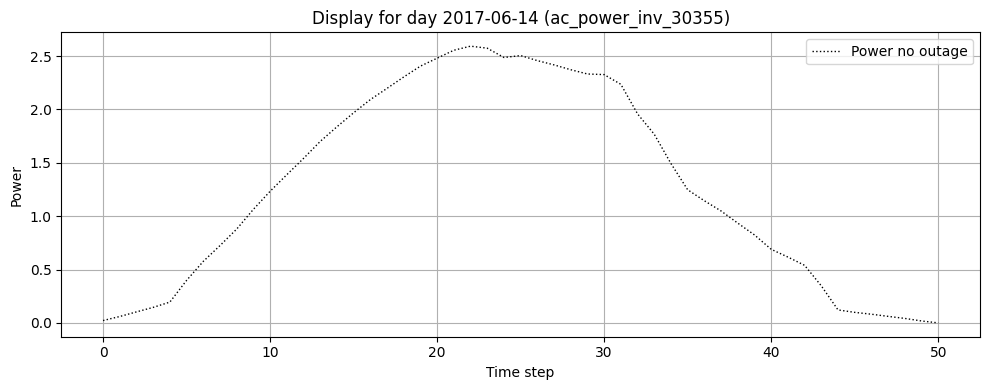

In [9]:
dhs.display(0,'ac_power_inv_30355')

In [10]:
sites = dhs.dil_mat.keys()

In [22]:
file_path = 'example.pkl.gz'
#m1 = load(file_path)

m1 = QLinear(sites,ndil = 51, target='ac_power_inv_30219')

In [ ]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='15GB')
print(client.dashboard_link)

http://127.0.0.1:8787/status


2025-08-08 07:06:36,561 - tornado.application - ERROR - Uncaught exception GET /graph/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/graph/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\tornado\web.py", line 1848, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\tornado\websocket.py", line 277, in get
    await self.ws_connection.accept_connection(self)
  File "c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\tornado\websocket.py", line 890, in accept_connection
    await self._accept_connection(handler)
  File "c:\Users\coren\Solar-data-tools\environments\ra_dev\Lib\site-packages\tornado\websocket.py", line 973, in _accept_connection
    await self._receive_frame_loop()
  File "c:\Users\coren\Solar-data-tools\enviro

In [26]:
client.close()

In [28]:
m1.fit_quantiles(dhs,param={'solver_quantiles' : 'mosek','client' : client})

FutureCancelledError: fit_dask-eb82517e-d44c-4277-9b65-d00236b1afea cancelled for reason: already forgotten.

In [43]:
m1.fit_linear({'nlag' : 3, 'num_basis' : 8})

In [45]:
m1.fit_residuals()

{'accuracy_train': 0.9223181257706535,
 'f1_score_train': 0.9158878504672897,
 'accuracy_val': 0.9014778325123153,
 'f1_score_val': 0.9029126213592233}

C:\Users\coren\Solar-data-tools\solar-data-tools\anomalydetector\detector_model.py:374: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


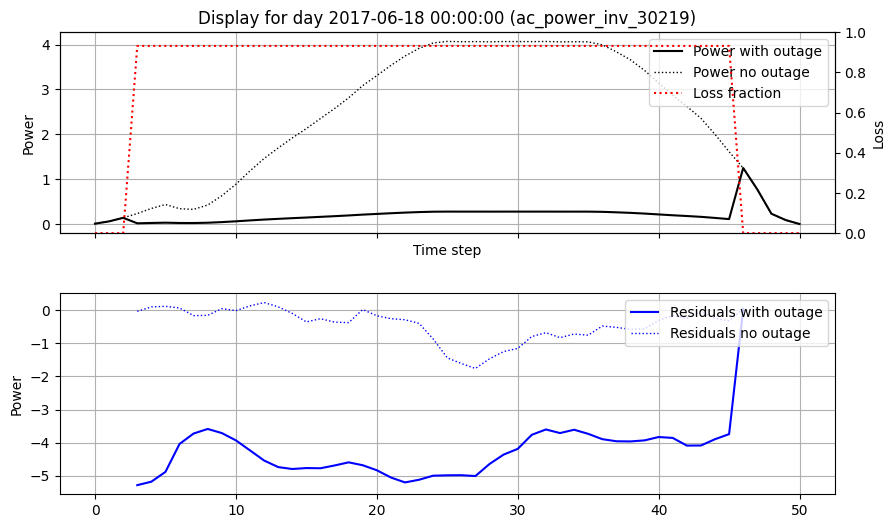

In [297]:
m1.display(3,multidata=dhs)

In [295]:
m1.coef_linear().shape

(44, 57)